# Deep Convolutional Neural Network - from scratch

#### (c) Koray Poyraz

TODO:
- Derivative function of Cross Entropy
- Bgerror for the reversed L-1 layer


In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Convolution

- filter - threshold - max pooling - normalisation

In [2]:
# black and white images
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# input_shape = (28, 28, 1)

# colored images
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

I think its a horse


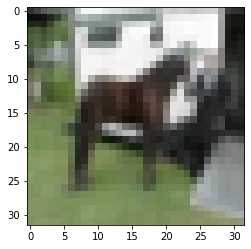

In [4]:
test_image = x_test[20]

input_shape = test_image.shape
filter_size = (3, 3)

print('I think its a horse')
plt.imshow(test_image);

In [122]:
filter_vertical_edge = np.array([
    [-1, 1, 0],
    [-2, 1, 0],
    [-1, 1, 0]])

filter_horizontal_edge = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]])


def conv_multi(source_pixels, filter_pixels):
    # apply multiplication stuff incl. sum
    return np.sum(np.multiply(source_pixels, filter_pixels))


def convolution_operation(image, input_shape, filters, kernel_size=(3, 3)):
    # apply convolution operation to 1 image with n filters and n filter size (aka kernel size)
    if filters is None:
        print('Please apply number of filters')
        return

    filter_output_size = input_shape[0]-kernel_size[0]+1

    depth = input_shape[-1] if len(input_shape) > 2 else 1
    boundary = kernel_size[0]

    feature_maps = []

    for filter_idx in range(0, len(filters)):
        filter_pixels = filters[filter_idx]
        feature_map = np.zeros((filter_output_size, filter_output_size))

        for zy in range(0, filter_output_size):
            for zx in range(0, filter_output_size):
                source_pixels = 0
                result = 0

                if depth > 1:
                    colors = []
                    for z in range(0, depth):
                        source_pixels = image[zy:boundary+zy, zx:boundary+zx, z]
                        color_output = conv_multi(source_pixels, filter_pixels)
                        colors.append(color_output)
                    result = sum(colors)
                else:
                    source_pixels = image[zy:boundary+zy, zx:boundary+zx]
                    result = conv_multi(source_pixels, filter_pixels)

                feature_map[zy, zx] = result

        feature_maps.append(feature_map)

    return feature_maps


def convolution_layer(images, input_shape, filters, kernel_size=(3, 3)):
    # apply convolution layer to all images with n filters and n filter size (aka kernel size)
    feature_maps_all_images = []

    depth = images.shape[-1] > 4

    for image in images:
        feature_maps = []

        if depth:
            for feature_map in images[0]:
                tmp_feature_maps = convolution_operation(feature_map, input_shape, filters, kernel_size)
                feature_maps += tmp_feature_maps
        else:
            feature_maps = convolution_operation(image, input_shape, filters, kernel_size)

        feature_maps_all_images.append(np.array(feature_maps))

    return np.array(feature_maps_all_images)


In [123]:
# for now we just use 1 image for testing and demonstration purposes
feature_maps = convolution_layer(np.array([test_image]), input_shape, [filter_vertical_edge, filter_horizontal_edge], filter_size)
feature_maps.shape

(1, 2, 30, 30)

In [3]:
def plot_process_step_image(images, title, figsize, cmap='viridis'):
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    axs[0].set_title('filter_vertical_edge')
    axs[0].imshow(images[0], cmap=cmap)
    axs[1].set_title('filter_horizontal_edge')
    axs[1].imshow(images[1], cmap=cmap)
    axs[2].set_title('original image')
    axs[2].imshow(images[2])
    fig.suptitle(title)
    fig.tight_layout()

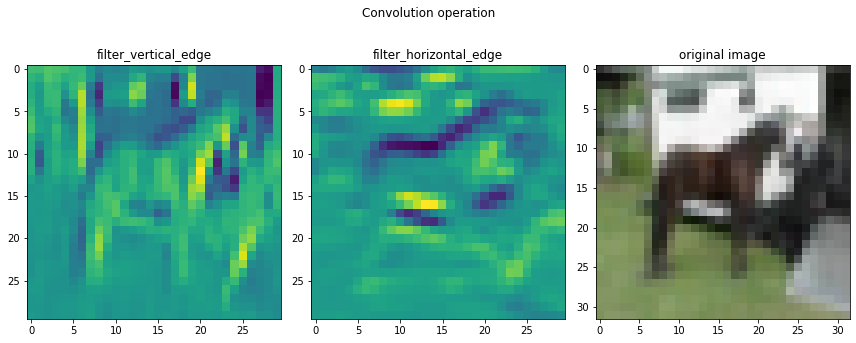

In [125]:
images = [feature_maps[0][0], feature_maps[0][1], test_image]
plot_process_step_image(images, 'Convolution operation', (12, 5))

In [127]:
test = convolution_layer(feature_maps, feature_maps[0][0].shape, [filter_vertical_edge, filter_horizontal_edge], filter_size)

In [128]:
test.shape

(1, 4, 28, 28)

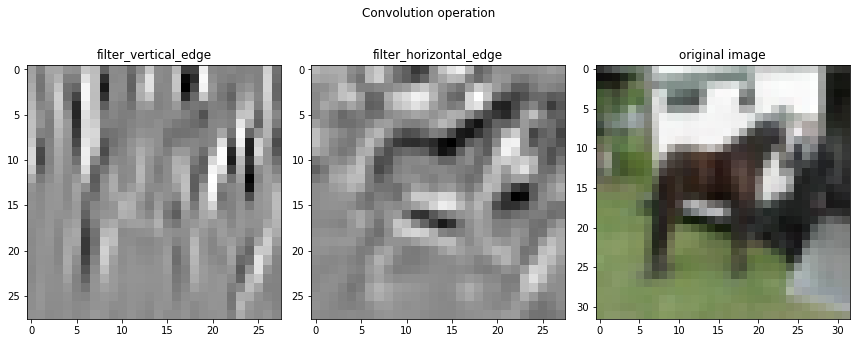

In [129]:
images = [test[0][0], test[0][1], test_image]
plot_process_step_image(images, 'Convolution operation', (12, 5), cmap='Greys')

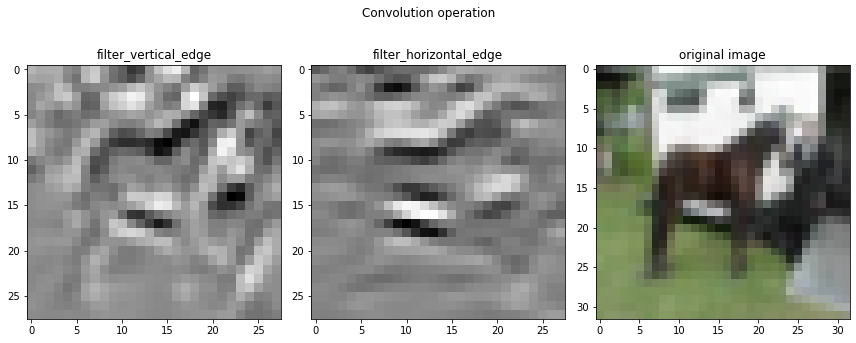

In [130]:
images = [test[0][2], test[0][3], test_image]
plot_process_step_image(images, 'Convolution operation', (12, 5), cmap='Greys')

Rectified linear (relu) activation over a whole feature map, with a maximum activation mimicking neuron firing rate


In [46]:
def activation_relu(x, max_activation=None):
    # ReLu activation function, max_activation is equal to the firing limit of a neuron
    return max(0.0, x) if max_activation is None else min(max(0.0, x), max_activation)

activation_relu_fn = np.vectorize(activation_relu)

def activation(feature_maps, max_activation=None):
    # apply ReLu on 1 image with n feature maps
    return [activation_relu_fn(feature_map.flatten(), max_activation).reshape(feature_map.shape) for feature_map in feature_maps]

def activation_layer(feature_maps_all_images, max_activation=None):
    # apply ReLu on all images with n feature maps
    return np.array([activation(feature_maps, max_activation) for feature_maps in feature_maps_all_images])

In [18]:
activation_maps = activation_layer(feature_maps, 3)

activation_maps.shape

(1, 2, 30, 30)

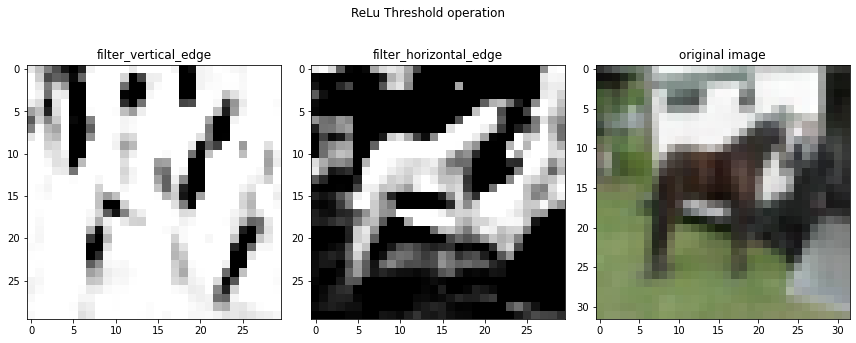

In [19]:
images = [activation_maps[0][0], activation_maps[0][1], test_image]
plot_process_step_image(images, 'ReLu Threshold operation', (12, 5), cmap='Greys')

Max pooling, the spatial extent of the pooling

In [20]:
def max_pooling(activation_maps, pooling_filter_size=2):
    # apply max pooling on 1 image with n feature maps
    pooling_maps = []

    output_size = int(activation_maps.shape[-1]/pooling_filter_size)

    for activation_map in activation_maps:
        pooling_map = np.zeros((output_size, output_size))

        for y in range(0, output_size):
            for x in range(0, output_size):
                activation_map_subpixels = activation_map[
                                           y*pooling_filter_size:pooling_filter_size*(y+1),
                                           x*pooling_filter_size:pooling_filter_size*(x+1)]
                pooling_map[y,x] = activation_map_subpixels.max()

        pooling_maps.append(pooling_map)
    return np.array(pooling_maps)


def max_pooling2d(activation_maps_all_images, pooling_size=2):
    # apply max pooling on all image with n feature maps
    return np.array([max_pooling(activation_maps, pooling_size) for activation_maps in activation_maps_all_images])

In [21]:
pooling_maps = max_pooling2d(activation_maps, 2)
pooling_maps.shape

(1, 2, 15, 15)

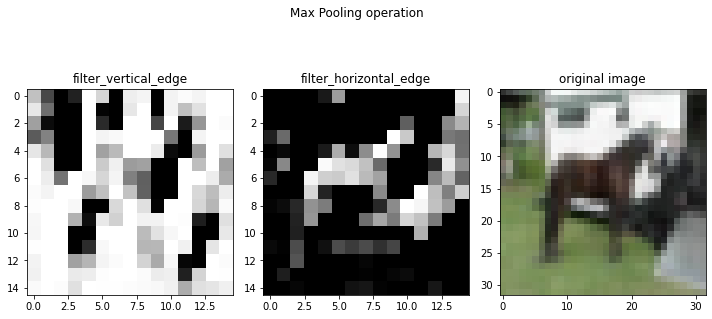

In [22]:
images = [pooling_maps[0][0], pooling_maps[0][1], test_image]
plot_process_step_image(images, 'Max Pooling operation', figsize=(10, 5), cmap='Greys')

Normalisation

In [23]:
def normalisation(pooling_maps):
    # apply normalisation on 1 image with n feature maps
    normalisation_maps = []

    for pooling_map in pooling_maps:
        tmp = pooling_map - pooling_map.mean()
        normalised_map = tmp / pooling_map.std()
        normalisation_maps.append(normalised_map)

    return np.array(normalisation_maps)


def normalisation2d(pooling_maps_all_images):
    # apply normalisation on all image with n feature maps
    return np.array([normalisation(pooling_maps) for pooling_maps in pooling_maps_all_images])

In [24]:
normalisation_maps = normalisation2d(pooling_maps)
normalisation_maps.shape

(1, 2, 15, 15)

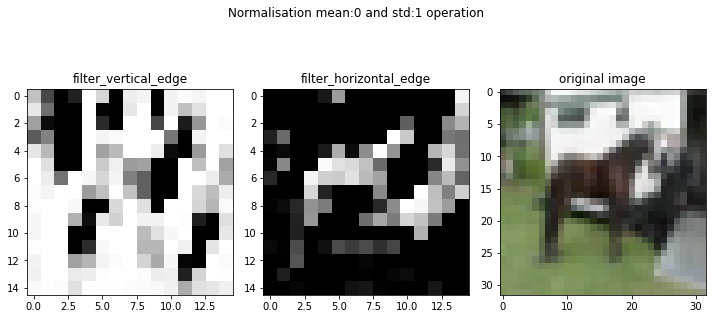

In [25]:
images = [normalisation_maps[0][0], normalisation_maps[0][1], test_image]
plot_process_step_image(images, 'Normalisation mean:0 and std:1 operation', figsize=(10, 5), cmap='Greys')

Vertical edge


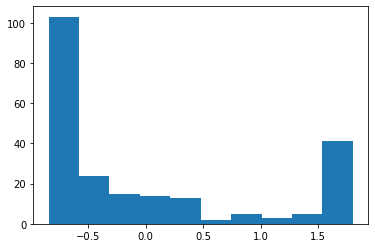

In [26]:
print('Vertical edge')
plt.hist(normalisation_maps[0][0].flatten())
plt.show()

Horizontal edge


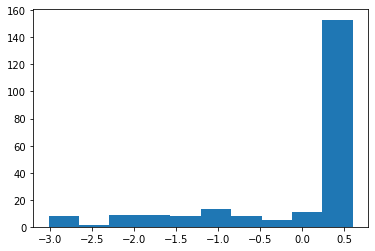

In [27]:
print('Horizontal edge')
plt.hist(normalisation_maps[0][1].flatten())
plt.show()

Flattening + Fully-connected layer

In [20]:
def flatten_layer(feature_maps_all_images):
    # for flattening the feature maps
    return np.array([feature_maps.flatten() for feature_maps in feature_maps_all_images])


def activation_fully_connect_layer(flatten_input_neurons_all_images, max_activation=3):
    # After flattening and fully connection we apply ReLu for activation
    return np.array([activation_relu_fn(input_neurons, max_activation) for input_neurons in flatten_input_neurons_all_images])


def fully_connect(input_flat_feature_map, output_neurons):
    # apply fully connect layer on 1 image with flattened feature map and calc weights (random) and bias (random)
    weights = np.random.rand(len(input_flat_feature_map), output_neurons) - 0.5
    bias = np.random.rand(1, output_neurons) - 0.5
    output = np.dot(input_flat_feature_map, weights) + bias
    return output


def fully_connect_layer(input_flatten_feature_map_all_images, output_neurons):
    # apply fully connect layer on all image with flattened n feature maps and calc weights (random) and bias (random)
    return np.array([fully_connect(flat_feature_map, output_neurons)[0] for flat_feature_map in input_flatten_feature_map_all_images])


In [21]:
# here we first flat the feature maps
flattened_layer = flatten_layer(normalisation_maps)

# then apply the flat as input for the full connection with eg 128 output neurons
fully_connected = fully_connect_layer(flattened_layer, output_neurons=128)

# then apply ReLu activation on the fully connected layer
activation_fully_connected = activation_fully_connect_layer(fully_connected, max_activation=3)

# dimensions
print(f'Flatten shape: {flattened_layer.shape}')
print(f'Fully connected 1st layer shape: {fully_connected.shape}')
print(f'ReLu activation 1st layer shape: {activation_fully_connected.shape}')

Flatten shape: (1, 450)
Fully connected 1st layer shape: (1, 128)
ReLu activation 1st layer shape: (1, 128)


Algorithmic expression of a softmax (normalised exponential) function

In [61]:
def softmax(input_activations):
    # here we apply the softmax activation function within the output layer of the neural network
    numerator = np.exp(input_activations)
    denominator = np.sum(np.exp(input_activations))
    softmax_output = numerator/denominator
    return softmax_output

def softmax_layer(input_activations_all_images):
    # image X classes
    return np.array([softmax(input_activation) for input_activation in input_activations_all_images])

In [28]:
# then apply the flat as input for the full connection with eg 128 output neurons
classes = 10
output_layer_fully_connected = fully_connect_layer(activation_fully_connected, output_neurons=classes)
softmax_results = softmax_layer(output_layer_fully_connected)

# get 1 image
one_image = softmax_results[0]
chosen_class = np.argmax(one_image)

In [29]:
print(f'Predicted class: {chosen_class}')
print('All probability:')
softmax_results

Predicted class: 8
All probability:


array([[1.81269249e-02, 3.16799505e-04, 1.25909980e-01, 4.81744304e-04,
        8.57671895e-03, 1.69735254e-03, 3.05292399e-04, 5.64097685e-04,
        7.32186343e-01, 1.11834747e-01]])

Set of functions for achieving backpropagation of error to affect the convolutional filter (kernel) structure

In [4]:
def relu_fn(x):
    return max(0, x)


relu = np.vectorize(relu_fn)


def relu_layer(feature_maps):
    # apply ReLu on 1 image with n feature maps
    return [relu(feature_map.flatten()).reshape(feature_map.shape) for feature_map in feature_maps]


def relu_derivative_fn(x):
    return 1 if x > 0 else 0


relu_derivative = np.vectorize(relu_derivative_fn)


def relu_derivative_layer(feature_maps):
    # apply ReLu on 1 image with n feature maps
    return [relu_derivative(feature_map.flatten()).reshape(feature_map.shape) for feature_map in feature_maps]


def softmax(input_activations):
    # here we apply the softmax activation function within the output layer of the neural network
    numerator = np.exp(input_activations)
    denominator = np.sum(numerator)
    softmax_output = numerator/denominator
    return softmax_output


def softmax_derivative(softmax_output):
    # here we apply the derivative of softmax function
    dS = softmax_output[0] * np.sum(softmax_output[1:])
    dX = np.sum(softmax_output)**2
    return dS/dX


def loss_cross_entropy(y, yhat):
    # someSoftmax = np.array([0.7, 0.1, 0.2])
    # y = np.array([1,0,0])
    # loss_cross_entropy(y, someSoftmax)
    return -(y*np.log(yhat))

# TODO
def loss_cross_entropy_derivative(y, yhat):
    return -(y*np.log(yhat))


In [69]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes feed forward
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

    def print_dimension(self):
        raise NotImplementedError


class ConvolutionLayer(Layer):
    def __init__(self, n_filters, kernel_size, activation, activation_prime):
        super().__init__()
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.activation_prime_func = activation_prime
        self.filters = [np.random.rand(kernel_size[0], kernel_size[1]) for _ in range(0, n_filters)]


    def conv_multi(self, source_pixels, filter_pixels):
        # apply multiplication stuff incl. sum
        return np.sum(np.multiply(source_pixels, filter_pixels))


    def convolution_operation(self, image):
        # apply convolution operation to 1 image with n filters and n filter size (aka kernel size)
        if self.filters is None:
            print('Please apply number of filters')
            return

        input_shape = image.shape

        filter_output_size = input_shape[0]-self.kernel_size[0]+1

        depth = input_shape[-1] if len(input_shape) > 2 else 1
        boundary = self.kernel_size[0]

        feature_maps = []

        for filter_idx in range(0, len(self.filters)):
            filter_pixels = self.filters[filter_idx]
            feature_map = np.zeros((filter_output_size, filter_output_size))

            for zy in range(0, filter_output_size):
                for zx in range(0, filter_output_size):
                    source_pixels = 0
                    result = 0

                    if depth > 1:
                        colors = []
                        for z in range(0, depth):
                            source_pixels = image[zy:boundary+zy, zx:boundary+zx, z]
                            color_output = self.conv_multi(source_pixels, filter_pixels)
                            colors.append(color_output)
                        result = sum(colors)
                    else:
                        source_pixels = image[zy:boundary+zy, zx:boundary+zx]
                        result = self.conv_multi(source_pixels, filter_pixels)

                    feature_map[zy, zx] = result

            feature_maps.append(feature_map)

        return feature_maps

    def convolution_layer(self, image):
        depth = image.shape[-1] > 4
        feature_maps = []

        if depth:
            for feature_map in image:
                tmp_feature_maps = self.convolution_operation(feature_map)
                feature_maps += tmp_feature_maps
        else:
            feature_maps = self.convolution_operation(image)

        return np.array(feature_maps)

    def normalisation(self, feature_maps):
        # apply normalisation on 1 image with n feature maps
        normalisation_maps = []

        for feature_map in feature_maps:
            tmp = feature_map - feature_map.mean()
            normalised_map = tmp / feature_map.std()
            normalisation_maps.append(normalised_map)

        return np.array(normalisation_maps)


    # computes feed forward
    def forward_propagation(self, input):
        self.input = input
        self.feature_maps = self.convolution_layer(self.input) #z
        self.a = self.activation(self.feature_maps) #a
        self.normalised = self.normalisation(self.a) #n
        return self.normalised


    # computes dE/dX for a given dE/dY
    def backward_propagation(self, output_error, learning_rate):
        delta_per_activation = self.activation_prime_func(self.a) * output_error #back-propagation error, relu * error
        delta_per_feature = [np.dot(feature_map, err) for feature_map, err in zip(self.feature_maps, delta_per_activation)] #back-propagation error, feature map * error

        input_errors = [np.dot(weight_filter, err) for weight_filter, err in zip(self.filters, delta_per_feature)] #back-propagation error, filter * error and becomes the input error for L-1

        self.filters = [np.min(filter, err) for filter, err in zip(self.filters, input_errors)] # tune the current weights

        return input_errors # error for L-1


    def print_dimension(self):
        return f'convolution layer: {self.kernel_size}'


class Flatten(Layer):
    def __init__(self):
        super().__init__()

    def forward_propagation(self, feature_maps):
        self.input = feature_maps
        # self.output = np.array([feature_maps.flatten() for feature_maps in self.input])
        self.output = self.input.flatten()
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        # because it is only flattening we can pass the error to L-1
        return output_error


    def print_dimension(self):
        return f'flatten: unknown'


class FullyConnect(Layer):
    state = True

    def __init__(self, output_size, activation_func, activation_prime_func):
        super().__init__()
        self.output_size = output_size
        self.activation_func = activation_func
        self.activation_prime_func = activation_prime_func


    def init_weights_bias(self, flattened_input):
        self.weights = np.random.rand(len(flattened_input), self.output_size) - 0.5
        self.bias = np.random.rand(1, self.output_size) - 0.5

    def forward_propagation(self, flattened_input):

        if self.state:
            self.init_weights_bias(flattened_input)
            self.state = False

        self.input = flattened_input
        self.z = np.dot(self.input, self.weights) + self.bias
        self.a = self.activation_func(self.z)
        return self.a


    def back_propagation(self, output_error, learning_rate):
        delta = self.activation_prime_func(self.a) * output_error #back-propagation error
        input_error = np.dot(delta, self.weights.T) #back-propagation error for the previous input, L-1
        weights_error = np.dot(self.input, delta) #dJdW

        self.weights -= weights_error * learning_rate
        self.bias -= delta * learning_rate

        return input_error


    def print_dimension(self):
        return f'output dense: {self.output_size}'


class DCNNetwork:
    def __init__(self):
        self.layers = []


    def add_layer(self, layer):
        self.layers.append(layer)


    def compile(self, loss_function, loss_function_prime, learning_rate):
        self.loss_function = loss_function
        self.loss_function_prime = loss_function_prime
        self.learning_rate = learning_rate

        [print(layer.print_dimension()) for layer in self.layers]


    def fit(self, x_train, y_train, epochs):

        L = len(x_train)

        for e in range(epochs):

            err = 0

            for j in range(L):

                output = x_train[j]

                for layer in self.layers:
                    output = layer.forward_propagation(output)

                err = self.loss_function(y_train[j], output)
                error = self.loss_function_prime(y_train[j], output)

                for back_layer in reversed(self.layers):
                    error = back_layer.back_propagation(error, self.learning_rate)

            print(f'epoch: {e} \t error={err}')

In [73]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

test_image = x_test[0]

In [74]:
colly1 = ConvolutionLayer(n_filters=32, kernel_size=(3, 3), activation=relu_layer, activation_prime=relu_derivative)
propagated1 = colly1.forward_propagation(test_image)

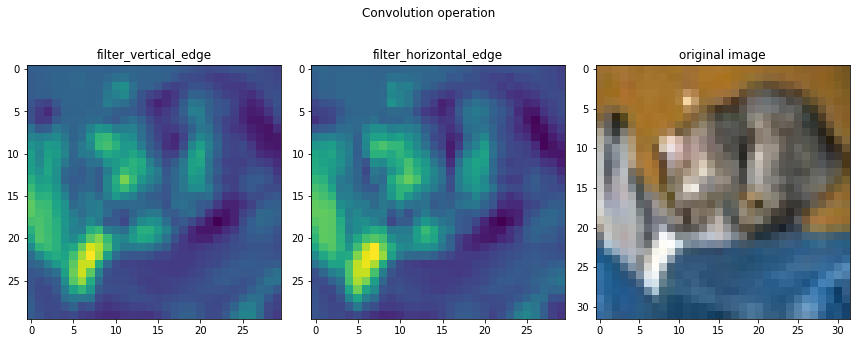

In [75]:
images = [propagated1[0], propagated1[2], test_image]
plot_process_step_image(images, 'Convolution operation', (12, 5))

Implementation of Convolutional neural network with two convolutional layers, a fully connected layer, and an output layer (pooling, thresholding and normalisation)

In [39]:
model = DCNNetwork()

model.add_layer(ConvolutionLayer(n_filters=32, kernel_size=(3, 3), activation=relu_layer, activation_prime=relu_derivative))
model.add_layer(ConvolutionLayer(n_filters=32, kernel_size=(3, 3), activation=relu_layer, activation_prime=relu_derivative))

model.add_layer(Flatten())

model.add_layer(FullyConnect(128, relu, relu_derivative))
model.add_layer(FullyConnect(10, softmax, softmax_derivative))

model.compile(loss_cross_entropy, loss_cross_entropy_derivative, learning_rate=0.1)


convolution layer: (3, 3)
convolution layer: (3, 3)
flatten: unknown
output dense: 128
output dense: 10


In [ ]:
model.fit(x_train, y_train)